In [54]:
from datascience import Table
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import copy
import mpl_scatter_density
import numpy as np
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import seaborn as sns; sns.set()
import geohash as gh
from haversine import haversine
%matplotlib inline

**1. Read Dataset**

**Train Set**

In [55]:
# Run start
data = pd.read_csv('train.csv')
data.head(2)
# Run end

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


In [56]:
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])

In [57]:
data = data.sort_values(by='pickup_datetime', ascending= True)

In [58]:
data['pickup_datetime'][0]

Timestamp('2016-03-14 17:24:55')

In [59]:
data['pickup_datetime'][data.shape[0]-1]

Timestamp('2016-04-05 14:44:25')

Number of columnns & Number of Observations

In [60]:
# number of columns
data.shape[1]

11

In [9]:
# number of rows
data.shape[0]

1458644

Training Date : [1,458,644 observations,11 features ]

**Test Set**

In [108]:
test = pd.read_csv('test.csv')
test.head(2)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N


In [6]:
# number of columns
test.shape[1]

9

In [7]:
# number of rows
test.shape[0]

625134

In [8]:
# find the columns that are in the training data and not in the test set.
data.columns.difference(test.columns)

Index(['dropoff_datetime', 'trip_duration'], dtype='object')

In [110]:
np.array(test['passenger_count']).max()

9

The test set doesn't contain all the features in the training data. It is missing the following columns: 
- Dropff datetime
- Trip duration

**2. Data Cleaning & Missing Values**

In [9]:
# Check if there is any NAN values in the train data
data.isnull().any().any()

False

In [10]:
# Check if there is any NAN values in the test data
test.isnull().any().any()

False

There is no missing values in the dataset

**Validate Consistency of the Data**

In this part the following conditions are checked for to ensure the consistenecy of the dataset: 
    - Dropoff time > pickup time
    - Trip duration = dropff time - pickup time
    - longitude is in the range [-180,180]
    - latitude is in the range [-90,90]
    - pickup & dropoff coordinates are within the coordinates of NYC
    - Passanger count < max capacity of yellow cabs in NYC
    - Passenger count is greater than zero

1. Check that dropoff time is greater than the pickup time.

In [97]:
# pickup time < dropoff time
(data['pickup_datetime'] < data['dropoff_datetime']).all()

True

2. Check that the longitude values are within range [0, 90] & latitude values are within the range [-180, 180].

In [91]:
# dropoff longitude values [-180, 180]
(data['dropoff_longitude'].between(-180,180, inclusive=True)).all()

True

In [92]:
# pickup longitude values [-180, 180]
(data['pickup_longitude'].between(-180,180, inclusive=True)).all()

True

In [93]:
# dropoff latitude values [-90, 90]
(data['dropoff_latitude'].between(-90,90, inclusive=True)).all()

True

In [94]:
# dropoff latitude values [-90, 90]
(data['pickup_latitude'].between(-90,90, inclusive=True)).all()

True

4. Check that the passenger count doesn't exceed the maximum capacity of NYC yellow cab.

In [95]:
# yellow cab passenger max capacity : src: https://www.tripsavvy.com/new-york-city-taxis-4026457
# 5 adults and one child
max_capacity = 5 + 1
(data['passenger_count'] <= max_capacity).all()

False

In [98]:
(data['passenger_count'] > 0 ).all()

False

In [45]:
data[data['passenger_count']==0]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
62744,id3917283,2,2016-06-06 16:39:09,2016-06-07 16:30:50,0,-73.776367,40.645248,-73.776360,40.645260,N,85901
136519,id3645383,2,2016-01-01 05:01:32,2016-01-01 05:01:36,0,-73.993134,40.757473,-73.993294,40.757538,N,4
194288,id2840829,2,2016-02-21 01:33:52,2016-02-21 01:36:27,0,-73.946243,40.772903,-73.946770,40.774841,N,155
217765,id3762593,1,2016-01-04 12:24:17,2016-01-04 13:01:48,0,-73.815224,40.700081,-73.950699,40.755222,N,2251
263809,id2154895,1,2016-05-23 23:37:37,2016-05-23 23:37:45,0,-73.861633,40.705029,-73.861633,40.705029,N,8
278290,id0796773,1,2016-02-07 17:23:48,2016-02-07 17:23:57,0,-73.954941,40.687866,-73.954742,40.687862,N,9
301600,id2091096,2,2016-01-01 23:52:46,2016-01-02 00:27:18,0,-73.993652,40.757046,-73.918869,40.757793,N,2072
303133,id0414625,2,2016-01-05 18:52:20,2016-01-05 18:52:35,0,-73.985291,40.738335,-73.985352,40.738361,N,15
337809,id0271506,2,2016-05-22 00:23:15,2016-05-22 00:23:56,0,-73.956718,40.777142,-73.956764,40.776958,N,41
375972,id3176865,2,2016-05-31 05:10:23,2016-05-31 05:10:38,0,-73.982468,40.727974,-73.982468,40.728001,N,15


There are rides with passenger count exceeding the maximum capacity and equal to zero. This will be examined further in the outliers analysis part

3. Check that the longitude & latitude values are withing the coordinates of NYC.
we got the bounding box of NYC using this site:https://gist.github.com/mishari/5ecfccd219925c04ac32

In [18]:
# Run start
# bounding box of NYC
# bbox = min latitude , max Latitude , min Longitude , max longitude 
bbox = [40.4773979187012,45.0158615112305,-79.7625122070312,-71.8527069091797]

In [19]:
bbox[1]

45.0158615112305

In [20]:
data['pickup_latitude'].between(bbox[0], bbox[1], inclusive=True).all()

False

In [21]:
data[~data['pickup_latitude'].between(bbox[0], bbox[1], inclusive=True)].shape[0]

40

In [22]:
data['dropoff_latitude'].between(bbox[0], bbox[1], inclusive=True).all()

False

In [23]:
data[~data['dropoff_latitude'].between(bbox[0], bbox[1], inclusive=True)].shape[0]

49

In [24]:
data['pickup_longitude'].between(bbox[2], bbox[3], inclusive=True).all()

False

In [25]:
data[~data['pickup_longitude'].between(bbox[2], bbox[3], inclusive=True)].shape[0]

10

In [26]:
data['dropoff_longitude'].between(bbox[2], bbox[3], inclusive=True).all()

False

In [27]:
data[~data['dropoff_longitude'].between(bbox[2], bbox[3], inclusive=True)].shape[0]

13

In [28]:
(data['trip_duration'] == (data['dropoff_datetime'] - data['pickup_datetime']).dt.seconds).all()

True

In [29]:
data[~(data['trip_duration'] == (data['dropoff_datetime'] - data['pickup_datetime']).dt.seconds)]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration


In [30]:
within_nyc = (data['pickup_longitude'].between(bbox[2], bbox[3], inclusive=True) & data['pickup_latitude'].between(bbox[0], bbox[1], inclusive=True))
within_nyc.all()
# run end

False

In [31]:
data[~within_nyc].shape[0]

43

In [32]:
within_nyc_drop = (data['dropoff_longitude'].between(bbox[2], bbox[3], inclusive=True) & data['dropoff_latitude'].between(bbox[0], bbox[1], inclusive=True))
within_nyc_drop.all()

False

In [33]:
data[~within_nyc_drop].shape[0]

54

**Data Visualization**

- **Vendors & Number of rides**

In [70]:
vendors = pd.DataFrame({'count':data[['vendor_id']].groupby('vendor_id').size()}).reset_index()

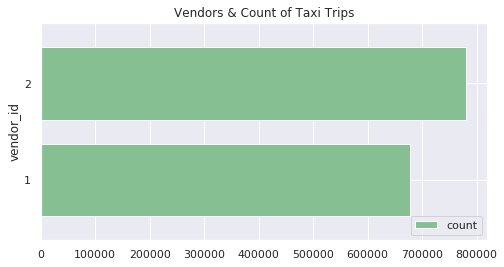

In [23]:
vendors.plot(x='vendor_id', y='count', kind='barh' ,figsize=(8, 4), color='#86bf91', zorder=2, width=0.75, title="Vendors & Count of Taxi Trips")

**Observations**

- vendor 2 has a higher share than vendor 1

- **Passanger Count**

In [40]:
passenger = pd.DataFrame({'count':data[['passenger_count']].groupby('passenger_count').size()}).reset_index()
passenger

,passenger_count,count
0,0,60
1,1,1033500
2,2,210302
3,3,59893
4,4,28403
5,5,78085
6,6,48332


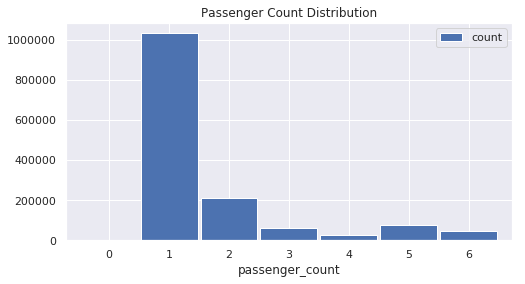

In [41]:
passenger.plot.bar(x='passenger_count', y='count', rot=0, figsize=(8, 4), color='b', zorder=2, width=0.95, title="Passenger Count Distribution")

**Observations**

- There are trips with passenger count = 0.
- passenger count greater than 6 is extremely rare to happen

- **Pickup Date & time**

- Day Hour

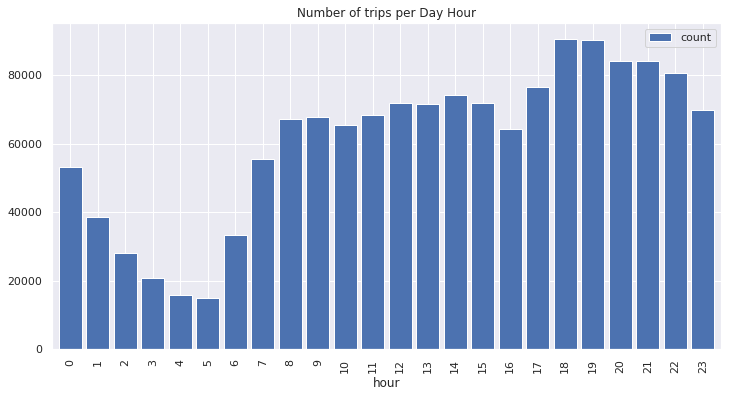

In [26]:
# convert pickup to datetime object
dayhour = pd.DataFrame({'hour': pd.to_datetime(data['pickup_datetime']).dt.hour}).groupby('hour').size()
dayhour = pd.DataFrame({'count': dayhour}).reset_index()
dayhour.plot.bar(x='hour', y='count', figsize=(12, 6), color='b', zorder=2, width=0.85, title="Number of trips per Day Hour")

**Observations**

- #of trips drastically decreases during late night after 1:00 AM and starts to decrease again after 6:00 AM

- Weekdays

In [118]:
# convert pickup to datetime object
weekdays = pd.DataFrame({'day': pd.to_datetime(data['pickup_datetime']).dt.day_name()}).groupby('day').size()
weekdays = pd.DataFrame({'count': weekdays}).reset_index()
weekdays

,day,count
0,Friday,223533
1,Monday,187418
2,Saturday,220868
3,Sunday,195366
4,Thursday,218574
5,Tuesday,202749
6,Wednesday,210136


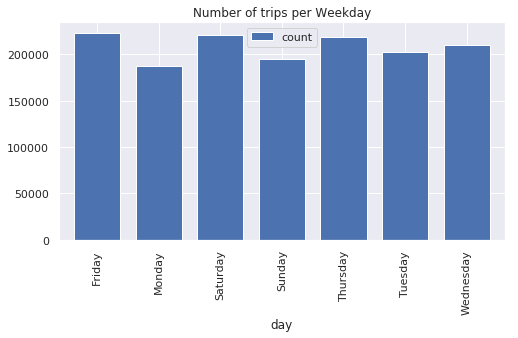

In [129]:
weekdays.plot.bar(x='day', y='count', figsize=(8, 4), color='b', zorder=2, width=0.75, title="Number of trips per Weekday")

**Observations**

- Friday has the highest number of trips
- Monday has the lowest number of trips

- Months

In [29]:
# convert pickup to datetime object
months = pd.DataFrame({'month': pd.to_datetime(data['pickup_datetime']).dt.month_name()}).groupby('month').size()
months = pd.DataFrame({'count': months}).reset_index()
months

,month,count
0,April,251645
1,February,238300
2,January,229707
3,June,234316
4,March,256189
5,May,248487


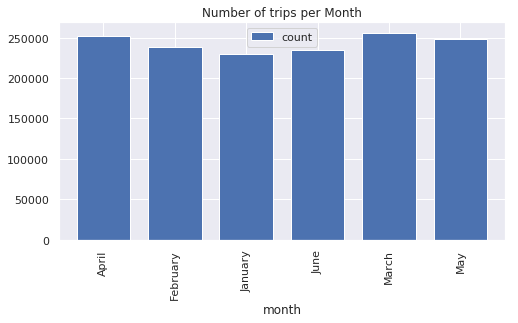

In [30]:
months.plot.bar(x='month', y='count', figsize=(8, 4), color='b', zorder=2, width=0.75, title="Number of trips per Month")

**Observations**

- The number of trips across the 6 months are quite similar. 

**Heatmaps**

**1. Month-Hour & Number of Pickups**

In [33]:
month_hour = pd.DataFrame({'month': pd.to_datetime(data['pickup_datetime']).dt.month_name(),
                           'hour' : pd.to_datetime(data['pickup_datetime']).dt.hour}).groupby(['month', 'hour']).size()
month_hour = pd.DataFrame({'count': month_hour}).reset_index()

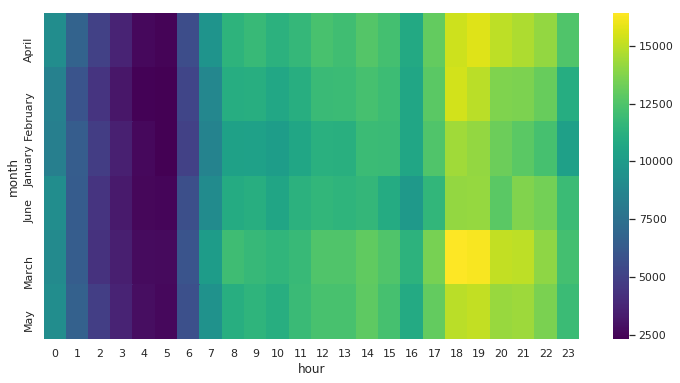

In [34]:
result = month_hour.pivot(index='month', columns='hour', values='count')
fig, ax = plt.subplots(figsize=(12,6))         # Sample figsize in inches
sns.heatmap(result, annot=False, fmt="g", cmap='viridis', ax=ax)
plt.show()

**2. Month-Day & Number of Pickups**

In [36]:
month_day = pd.DataFrame({'month': pd.to_datetime(data['pickup_datetime']).dt.month_name(),
                           'day' : pd.to_datetime(data['pickup_datetime']).dt.day_name()}).groupby(['month', 'day']).size()
month_day = pd.DataFrame({'count': month_day}).reset_index()

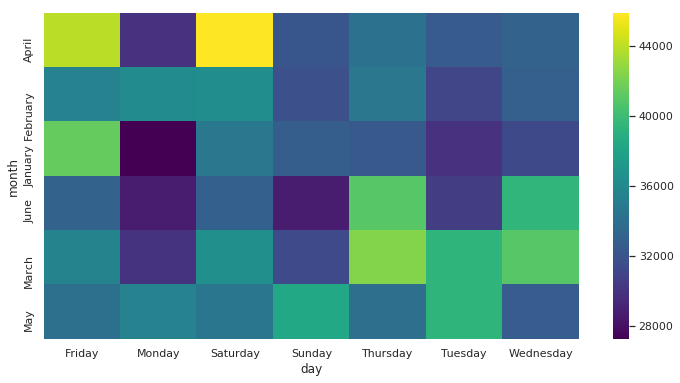

In [38]:
result = month_day.pivot(index='month', columns='day', values='count')
fig, ax = plt.subplots(figsize=(12,6))         # Sample figsize in inches
sns.heatmap(result, annot=False, fmt="g", cmap='viridis', ax=ax)
plt.show()

**1. Day-Hour & Number of Pickups**

In [42]:
day_hour = pd.DataFrame({'day': pd.to_datetime(data['pickup_datetime']).dt.day_name(),
                           'hour' : pd.to_datetime(data['pickup_datetime']).dt.hour}).groupby(['day', 'hour']).size()
day_hour = pd.DataFrame({'count': day_hour}).reset_index()

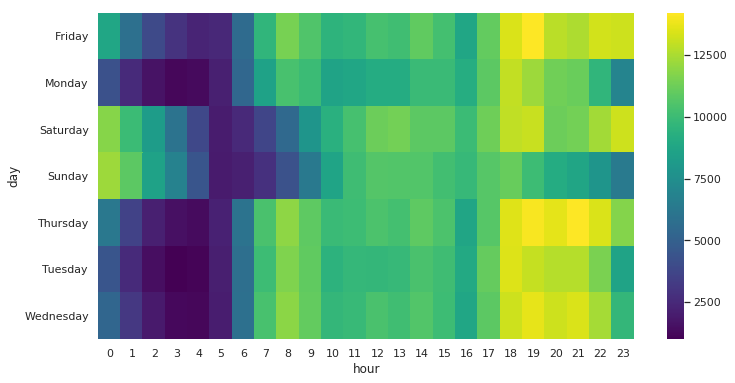

In [43]:
result = day_hour.pivot(index='day', columns='hour', values='count')
fig, ax = plt.subplots(figsize=(12,6))         # Sample figsize in inches
sns.heatmap(result, annot=False, fmt="g", cmap='viridis', ax=ax)
plt.show()

**Observations**

- Taxi rides increased in late night in the weekend. May be because people often go out more during weekends than weekdays.
- Taxi rides in the weekdays during morning (after 6:00 AM) are higher than weekends. This could be explained by office people who go to work during weekdays and rest during weekends.

**Pickup Longitude & Pickup Latitude**

In [42]:
# list of longitudes & latitudes and the bounding box of new york
def density_map(latitudes, longitudes , bbox):  
    norm = ImageNormalize(vmin=0., vmax=1000, stretch=LogStretch())
    plt.figure(figsize=(15,15))
    ax = plt.subplot(1, 1, 1, projection='scatter_density')

    xmin = bbox[0]
    xmax = bbox[1]
    ymin = bbox[2]
    ymax = bbox[3]
    
    xmin = -74.15
    xmax = -73.75
    ymin = 40.62
    ymax = 40.85
    
    aspect = 1 / np.cos(np.radians(0.5 * (ymin + ymax)))

    ax.scatter_density(longitudes, latitudes, cmap='plasma', norm=norm)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel
    ax.set_aspect(aspect)

In [43]:
# Coordinates of new york's city center
nyc = [74.0060, 40.7128]  

**Pickup Locations**

In [44]:
# Separate the latitude and longitude values from our list of coordinates
pickup_lat = np.array(data['pickup_latitude'])
pickup_long = np.array(data['pickup_longitude'])

In [45]:
# bounding box of the pickup locations
# bbox = min Longitude , max longitude , min latitude , max Latitude , 
bbox = []
bbox.append(np.min(pickup_long))
bbox.append(np.max(pickup_long))
bbox.append(np.min(pickup_lat))
bbox.append(np.max(pickup_lat))

/home/manar/.virtualenvs/data_science/lib/python3.6/site-packages/mpl_scatter_density/generic_density_artist.py:74: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/manar/.virtualenvs/data_science/lib/python3.6/site-packages/mpl_scatter_density/generic_density_artist.py:79: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


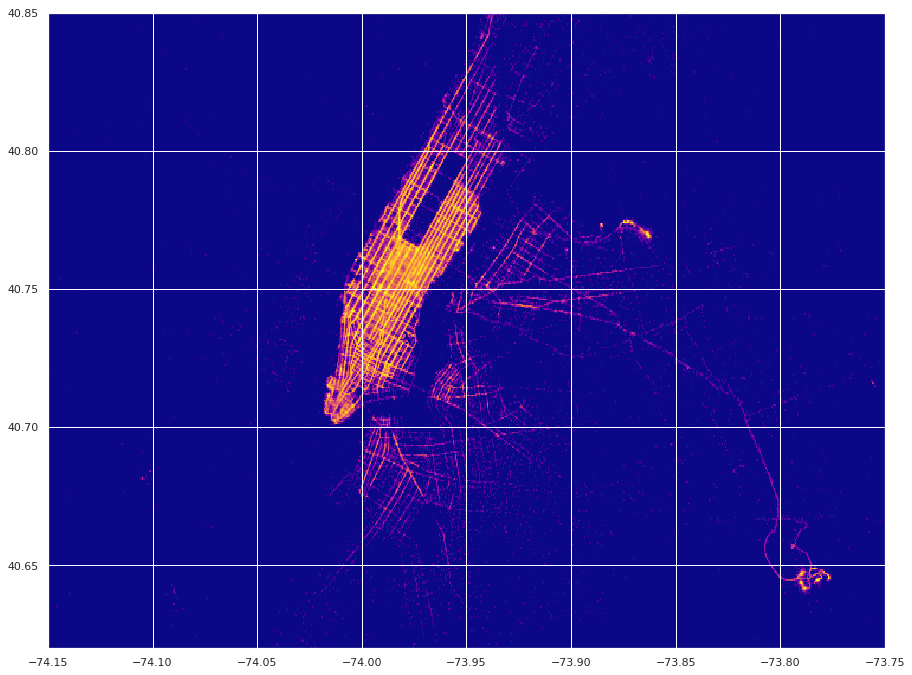

In [46]:
# Render the map
density_map(pickup_lat, pickup_long, bbox)

**Observations**

- What are the busiest routes ?

**Dropoff Locations**

In [47]:
# Separate the latitude and longitude values from our list of coordinates
dropoff_lat = np.array(data['dropoff_latitude'])
dropoff_long = np.array(data['dropoff_longitude'])

In [48]:
# bounding box of the pickup locations
# bbox = min Longitude , max longitude , min latitude , max Latitude , 
bbox = []
bbox.append(np.min(dropoff_long))
bbox.append(np.max(dropoff_long))
bbox.append(np.min(dropoff_lat))
bbox.append(np.max(dropoff_lat))

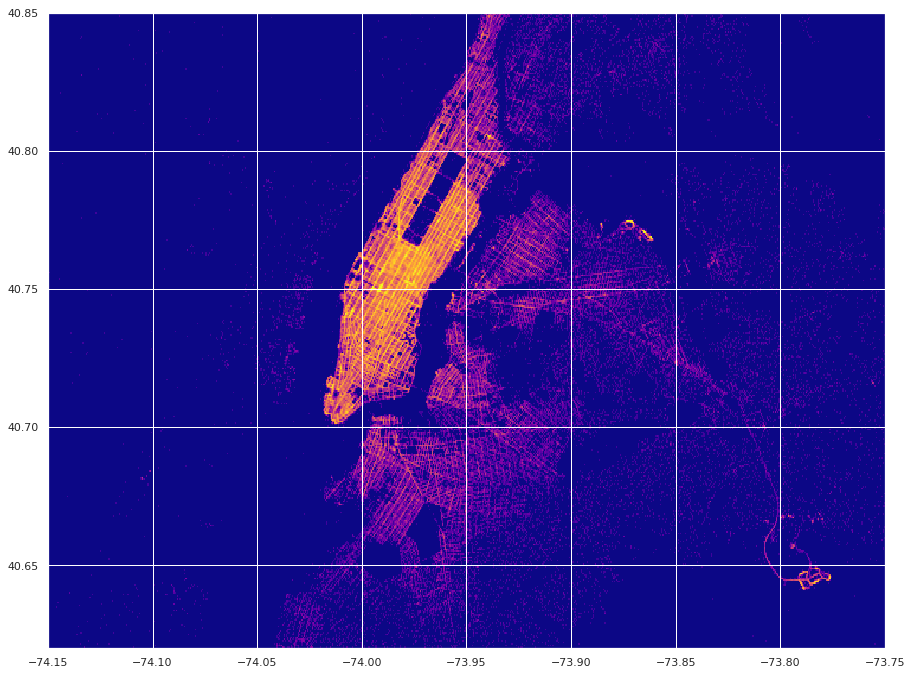

In [49]:
# Render the map
density_map(dropoff_lat, dropoff_long, bbox)

**Store and Fwd Flag**

This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server 
    - Y : store and forward
    - N : not a store and forward trip.

In [40]:
store_fwd_flag = pd.DataFrame({'count':data[['store_and_fwd_flag']].groupby('store_and_fwd_flag').size()}).reset_index()

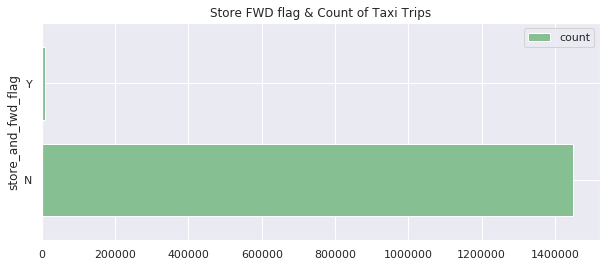

In [42]:
store_fwd_flag.plot(x='store_and_fwd_flag', y='count', kind='barh' ,figsize=(10, 4), color='#86bf91', zorder=2, width=0.75, title="Store FWD flag & Count of Taxi Trips")

**Observations**

- There are small number of trips that stored the trip information in the vehicle's memory before sending it to the server

**Trip Duration**

In [138]:
t = Table().with_columns('trip_duration',  np.array(data['trip_duration']))

In [7]:
min_dur = np.min(data['trip_duration'])
min_dur

1

In [8]:
max_dur = np.max(data['trip_duration'])
max_dur

3526282

In [33]:
max_day = max_dur / (24*60*60)
max_day

40.81344907407407

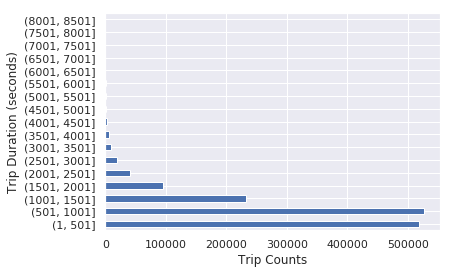

In [36]:
data['trip_duration'].groupby(pd.cut(data['trip_duration'], np.arange(1,9000,500))).count().plot(kind='barh')
plt.xlabel('Trip Counts')
plt.ylabel('Trip Duration (seconds)')
plt.show()

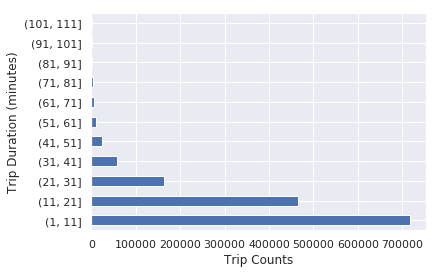

In [37]:
(data['trip_duration']/60).groupby(pd.cut((data['trip_duration']/60), np.arange(1,120,10))).count().plot(kind='barh')
plt.xlabel('Trip Counts')
plt.ylabel('Trip Duration (minutes)')
plt.show()

**Observations**

- There are trips with very small duration about 1 seconds
- There are trips with large durations around 350,00000 seconds ~ 40 days, which is very unlikely to happend and must have been a recording mistake
- Most of the trip took around 10 minutes to be completed

**Outliers Analysis**

The outliers existed mainly in the following columns: 
    - passenger count, with passenger count =0 and exceeding 6
    - store and fwd flag
    - trip duration

**1. Passenger Count Outliers**

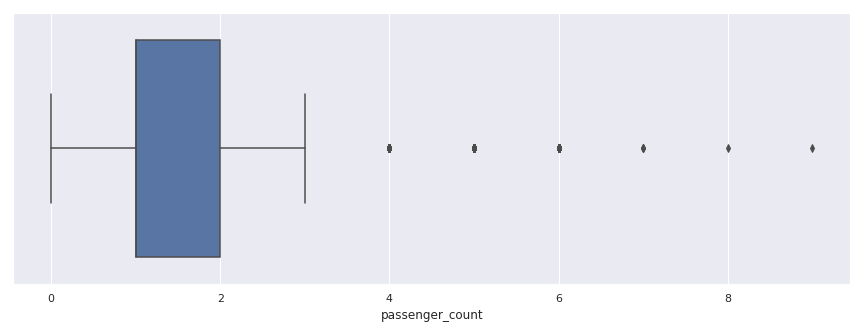

In [61]:
plt.figure(figsize = (15,5))
sns.boxplot(data.passenger_count)
plt.show()

In [62]:
pass_zero = data[data['passenger_count'] == 0]
pass_zero

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
136519,id3645383,2,2016-01-01 05:01:32,2016-01-01 05:01:36,0,-73.993134,40.757473,-73.993294,40.757538,N,4
301600,id2091096,2,2016-01-01 23:52:46,2016-01-02 00:27:18,0,-73.993652,40.757046,-73.918869,40.757793,N,2072
217765,id3762593,1,2016-01-04 12:24:17,2016-01-04 13:01:48,0,-73.815224,40.700081,-73.950699,40.755222,N,2251
303133,id0414625,2,2016-01-05 18:52:20,2016-01-05 18:52:35,0,-73.985291,40.738335,-73.985352,40.738361,N,15
722399,id1593144,1,2016-01-08 21:55:27,2016-01-08 22:01:52,0,-73.980957,40.742142,-73.986122,40.729488,N,385
727514,id1857858,2,2016-01-09 01:53:24,2016-01-09 01:53:26,0,-73.956123,40.668156,-73.956085,40.668110,N,2
875056,id3533680,1,2016-01-10 04:17:21,2016-01-10 04:17:24,0,-73.993195,40.598701,-73.993195,40.598701,N,3
412172,id2247129,2,2016-01-13 11:50:12,2016-01-13 12:16:08,0,-73.965027,40.775269,-73.973450,40.840618,N,1556
383407,id3493269,2,2016-01-14 19:09:41,2016-01-14 19:09:48,0,-73.904709,40.758099,-73.904716,40.758148,N,7
1049209,id1846091,2,2016-01-16 00:50:18,2016-01-16 00:51:36,0,-73.919167,40.686878,-73.919151,40.686874,N,78


Since , it is very unlikely to have a trip with passenger count equal to zero, it must have been a mistake in recording the data

In [63]:
# run start
# drop outliers
pass_outlier = data[(data['passenger_count'] == 9) | (data['passenger_count'] == 7) | (data['passenger_count'] == 8)]
data = data.drop(index = pass_outlier.index)

**Imputing Passenger Counter with Mean**

- Outliers in the passenger count: 
    - Trips with passanger count = 9 & 8 & 7 are extremely rare. Who took those rides and from which pickup location and to which dropoff location ? 

**Store and Fwd Flag**

In [64]:
store_flag = data[data['store_and_fwd_flag'] == 'Y']
store_flag.shape[0]

8045

Around 8000 trips didn't report the trip information directly to the server. This might have been due to the loss of connection. 

**3. Trip Duration**

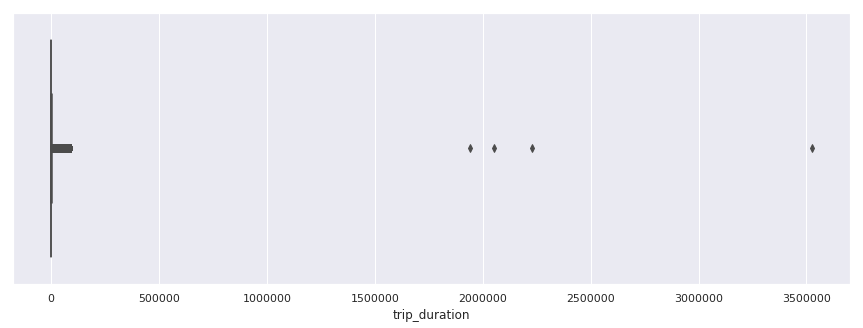

In [65]:
plt.figure(figsize=(15,5))
sns.boxplot(data['trip_duration'])
plt.show()

**Trips with duration exceeding one day**

In [66]:
duration_outlier = data[data['trip_duration']>= (60*60*24)]
duration_outlier

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,N,1939736
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,N,2227612
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,N,2049578
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,N,3526282


Most of these trips are done by vendor 1 and with small number of passengers. Since these records are very unlikely to be true and must have been due to a record mistake. We decided to remove them from the dataset in order not to bias the prediction model.

In [67]:
data = data.drop(index = duration_outlier.index)

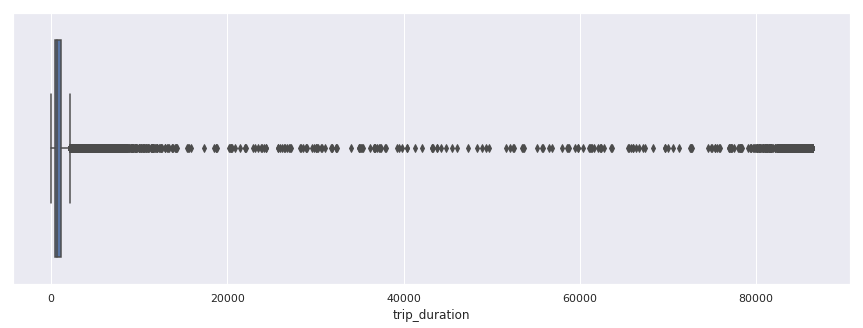

In [13]:
plt.figure(figsize=(15,5))
sns.boxplot(data['trip_duration'])
plt.show()

**Pickup Location**

In [68]:
location_outlier = data[~(within_nyc & within_nyc_drop)]
data = data.drop(index = location_outlier.index)

In [15]:
# Run End
data.to_csv('cleaned.csv', index=False)

**Dataset Descriptive Statistics**

- Estimate mean & median of passenger count
- Estimate mean & median of trip duration

**Feature Engineering**

1. Discrete Time 
2. Discrete Location 
3. Distance between the pickup and dropoff location
4. Estimated haversine time

In this part , we convert time column to discrete values. The new transformed features include: 
        - Daily minute
        - Time bin (time is divided into bins with one hour difference)
        - Day
        - Month
        - is_weekend

In [162]:
data['pickup_day'] = pd.to_datetime(data['pickup_datetime']).dt.day_name()
data['pickup_month'] = pd.to_datetime(data['pickup_datetime']).dt.month_name()
data['is_weekend'] = (pd.to_datetime(data['pickup_datetime']).dt.day_name() == 'Saturday') | (pd.to_datetime(data['pickup_datetime']).dt.day_name() == 'Sunday')

In [163]:
# convert time to bins
data['time_bin'] = pd.to_datetime(data['pickup_datetime']).dt.hour

In [164]:
data['pickup_daily_minute'] = pd.to_datetime(data['pickup_datetime']).dt.minute

In [165]:
# transform minutes to daily minute
data['pickup_daily_minute'] = data.apply(lambda x: x.pickup_daily_minute * 60 + int(x.time_bin), axis=1)

In this part, we convert pair values of longitude and latitude to a discrete value using the geohash python library. 

In [110]:
data['pickup_geohash'] = data.apply(lambda x: gh.encode(x.pickup_latitude, x.pickup_longitude, precision=5), axis=1)

In [111]:
data['dropoff_geohash'] = data.apply(lambda x: gh.encode(x.dropoff_latitude, x.dropoff_longitude, precision=5), axis=1)

In [59]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,pickup_month,time_cat,is_weekend,time_bin,pickup_geohash,dropoff_geohash
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Monday,March,17,False,17,dr5ru,dr5ru
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Sunday,June,0,True,0,dr5ru,dr5rs
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,Tuesday,January,11,False,11,dr5ru,dr5re
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,Wednesday,April,19,False,19,dr5re,dr5re
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,Saturday,March,13,True,13,dr72h,dr72h


In this part, we compute the distance between the pickup and dropoff locations using the harversine distance

In [177]:
data['distance'] = data.apply(lambda x: haversine((x.pickup_latitude, x.pickup_longitude), 
                                                (x.dropoff_latitude, x.dropoff_longitude)), axis=1)

In this part, we compute the haversine time between the pickup and dropoff locations using the harversine time equation

In [188]:
# compute average speed ~ distance / time --> km/s
avg_speed = np.mean(data['distance'] / data['trip_duration'])
avg_speed

0.004006463443151366

In [189]:
data['haversine_time'] = data.apply(lambda x: x.distance / avg_speed, axis=1)

In [180]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,pickup_month,is_weekend,time_bin,pickup_daily_minute,distance,haversine_time
96469,id0190469,2,2016-01-01 00:00:17,2016-01-01 00:14:26,5,-73.981743,40.719158,-73.938828,40.829182,N,849,Friday,January,False,0,0,12.756638,3184.023264
223872,id1665586,1,2016-01-01 00:00:53,2016-01-01 00:22:27,1,-73.985085,40.747166,-73.958038,40.717491,N,1294,Friday,January,False,0,0,4.010137,1000.919615
713067,id1210365,2,2016-01-01 00:01:01,2016-01-01 00:07:49,5,-73.965279,40.801041,-73.947479,40.815170,N,408,Friday,January,False,0,60,2.170875,541.844597
652463,id3888279,1,2016-01-01 00:01:14,2016-01-01 00:05:54,1,-73.982292,40.751331,-73.991341,40.750340,N,280,Friday,January,False,0,60,0.770148,192.226820
722901,id0924227,1,2016-01-01 00:01:20,2016-01-01 00:13:36,1,-73.970108,40.759800,-73.989357,40.742989,N,736,Friday,January,False,0,60,2.474579,617.648349


**Merge With the Weather Data**

**Feature Relations**

1. Vendor and trip duration

1. Pickup Hour and trip duration

In [166]:
hour_duration = data.groupby('time_bin')['trip_duration'].mean()

Text(0, 0.5, 'Avg Trip Duration')

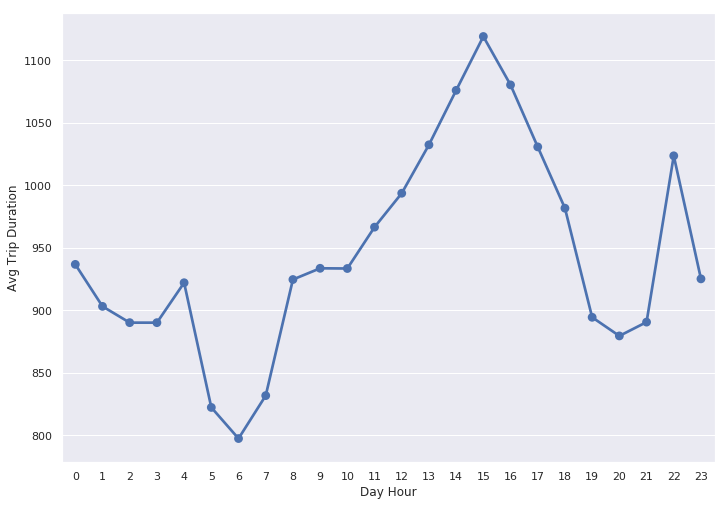

In [167]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.pointplot( hour_duration.index, hour_duration, figsize=(15,5))
plt.xlabel('Day Hour')
plt.ylabel('Avg Trip Duration')

**Observation**

- Avg trip duration is lowest during the morning 6:00 AM due to low traffic
- Avg trip duration is highest around 3:00 PM due to high traffic

2. Pickup Day & Avg trip duration

In [168]:
day_duration = data.groupby('pickup_day')['trip_duration'].mean()

Text(0, 0.5, 'Avg Trip Duration')

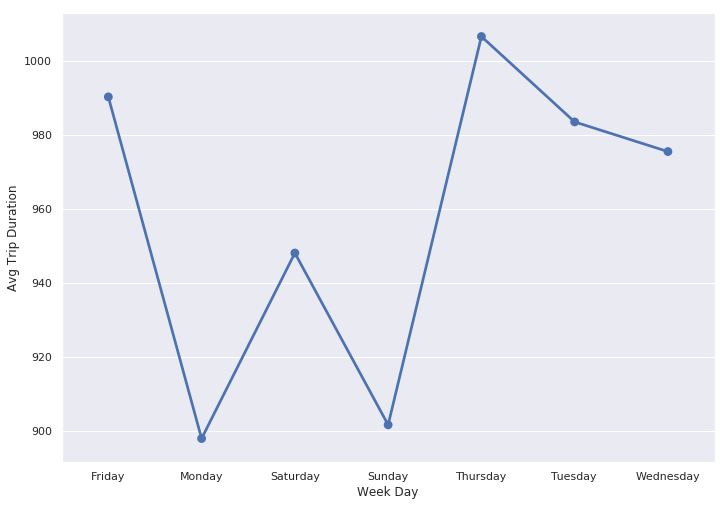

In [169]:
sns.pointplot( day_duration.index, day_duration, figsize=(15,5))
plt.xlabel('Week Day')
plt.ylabel('Avg Trip Duration')

**Observations**

- Weekends (saturday and sunday) have low avg trip duration.
- Other weekdays like friday and thursday have a a higher avg trip duration

3. Avg trip duration & Pickup Month

Text(0, 0.5, 'Avg Trip Duration')

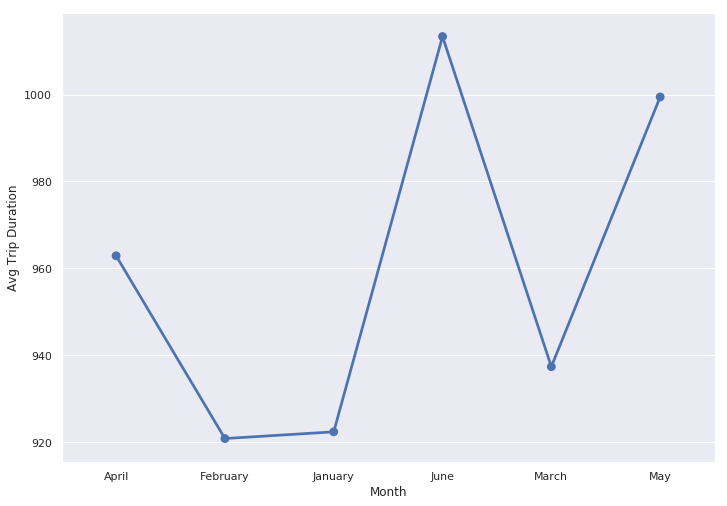

In [170]:
month_duration = data.groupby('pickup_month')['trip_duration'].mean()
sns.pointplot( month_duration.index, month_duration, figsize=(10,5))
plt.xlabel('Month')
plt.ylabel('Avg Trip Duration')

- Avg trip duration is highest during june and may which are considered rainy seasons. 
- And it is lowest during februrary and january

4. Avg Trip Duration & vendor

Text(0, 0.5, 'Avg Trip Duration')

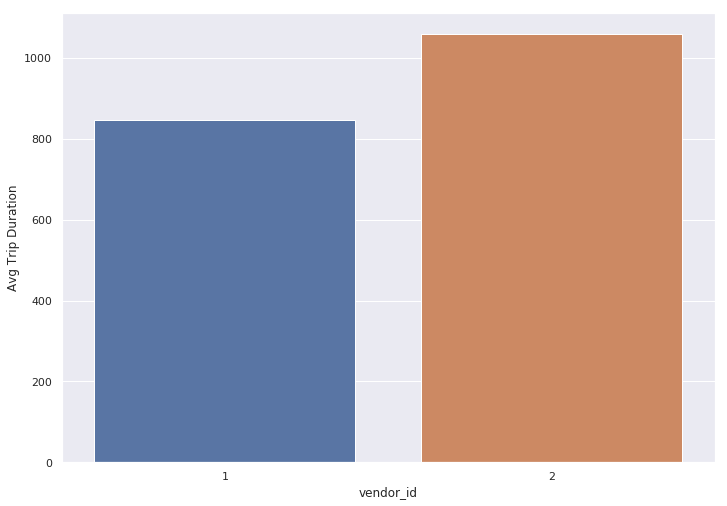

In [175]:
vendor_duration = data.groupby('vendor_id')['trip_duration'].mean()
sns.barplot(vendor_duration.index, vendor_duration)
plt.xlabel('vendor_id')
plt.ylabel('Avg Trip Duration')

- vendor 2 has a higher avg trip duration

**Month Hour Heatmap**

In [207]:
month_hour_duration = data.groupby(['pickup_month', 'time_bin'])['trip_duration'].mean()
month_hour_duration = pd.DataFrame({'trip_duration': month_hour_duration}).reset_index()

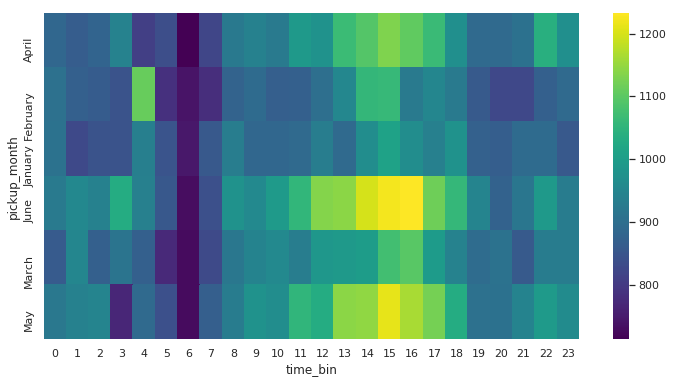

In [211]:
result = month_hour_duration.pivot(index='pickup_month', columns='time_bin', values='trip_duration')
fig, ax = plt.subplots(figsize=(12,6))         # Sample figsize in inches
sns.heatmap(result, annot=False, fmt="g", cmap='viridis', ax=ax)
plt.show()

**Day Hour Heatmap**

In [212]:
day_hour_duration = data.groupby(['pickup_day', 'time_bin'])['trip_duration'].mean()
day_hour_duration = pd.DataFrame({'trip_duration': day_hour_duration}).reset_index()

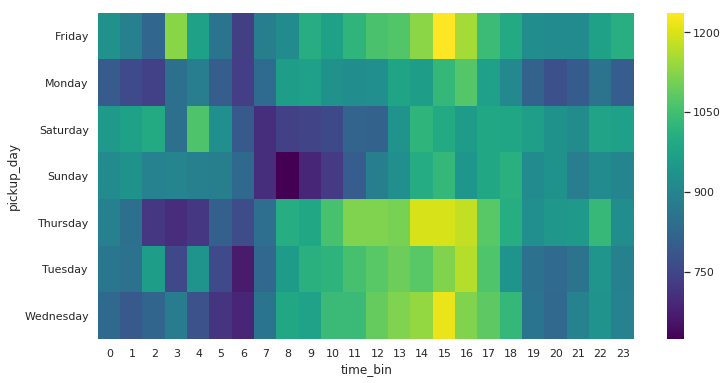

In [213]:
result = day_hour_duration.pivot(index='pickup_day', columns='time_bin', values='trip_duration')
fig, ax = plt.subplots(figsize=(12,6))         # Sample figsize in inches
sns.heatmap(result, annot=False, fmt="g", cmap='viridis', ax=ax)
plt.show()

5. Distance and avg trip duration

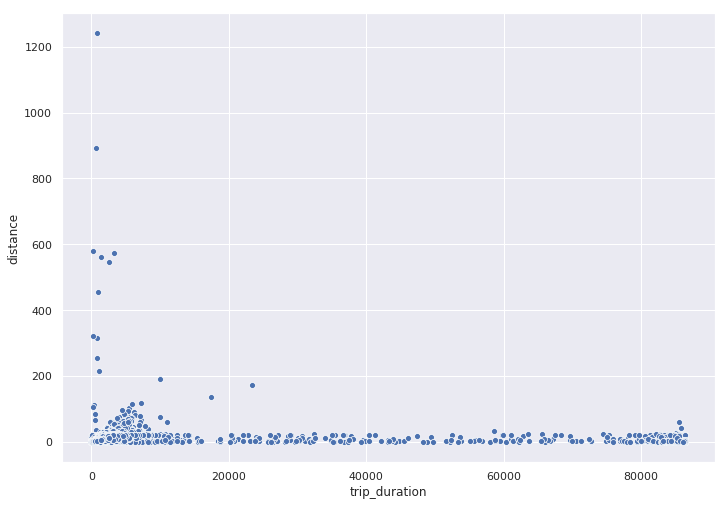

In [194]:
ax = sns.scatterplot(x="trip_duration", y="distance", data=data)

There seems to be no correlation between the trip duration and the distance travelled. This is most probaly due to wrong readings

In [200]:
# remove data with distance = 0 
data = data[~((data['distance']==0) & (data['trip_duration'] > 60))]

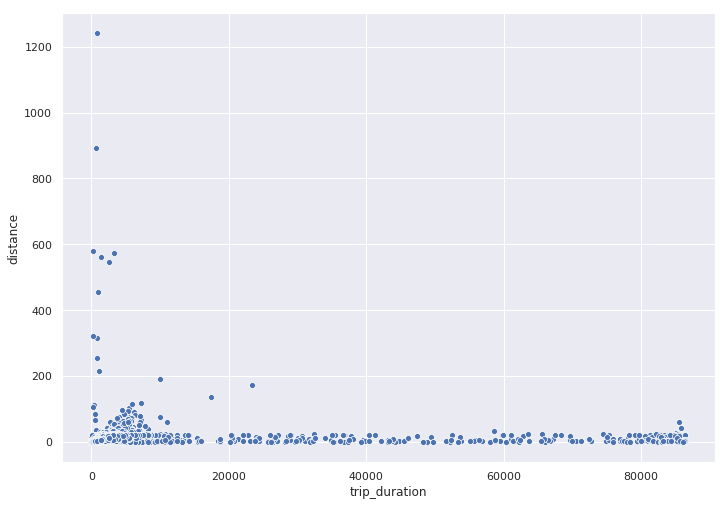

In [201]:
ax = sns.scatterplot(x="trip_duration", y="distance", data=data)

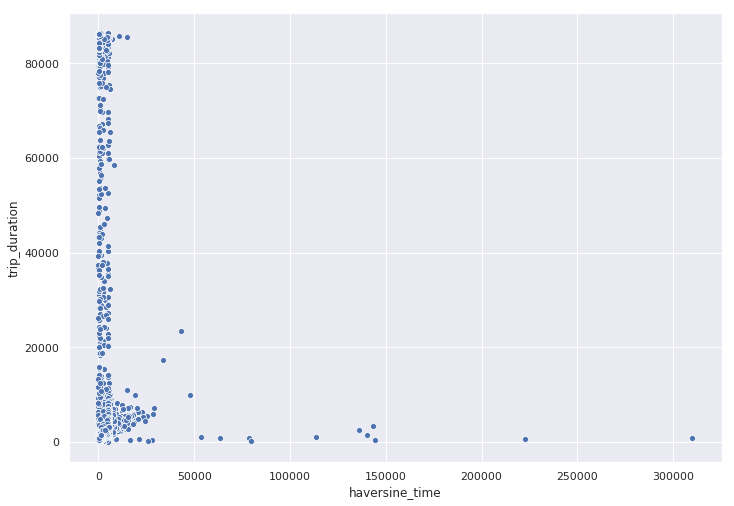

In [205]:
ax = sns.scatterplot(x="haversine_time", y="trip_duration", data=data)

**Features for Prediction Model**

**1. Predicting Trip Duration**

In this part , we finialize the features that will be used for training the model for predicting the trip duration.

In [114]:
features = ['pickup_geohash',
            'dropoff_geohash',
            'time_bin',
            'is_weekend',
            'pickup_month',
            'pickup_day',
            'pickup_daily_minute',
            'passenger_count',
            'vendor_id',
            'trip_duration',
            'distance',
            'haversine_time']
model_data = data[features]

In [50]:
import requests
source_coordinates = '18.21231,42.50830;'
dest_coordinates = '18.20971,42.50075'
url =  'http://router.project-osrm.org/route/v1/driving/'+source_coordinates+dest_coordinates

payload = {"steps":"true","geometries":"geojson"}

response = requests.get(url,params=payload)

data = response.json()

In [51]:
data

{'routes': [{'geometry': {'coordinates': [[18.271908, 42.538963],
     [18.271908, 42.538963]],
    'type': 'LineString'},
   'legs': [{'summary': '',
     'weight': 0,
     'duration': 0,
     'steps': [{'intersections': [{'out': 0,
         'entry': [True],
         'bearings': [234],
         'location': [18.271908, 42.538963]}],
       'driving_side': 'right',
       'geometry': {'coordinates': [[18.271908, 42.538963],
         [18.271908, 42.538963]],
        'type': 'LineString'},
       'mode': 'driving',
       'maneuver': {'bearing_after': 234,
        'bearing_before': 0,
        'location': [18.271908, 42.538963],
        'type': 'depart'},
       'weight': 0,
       'duration': 0,
       'name': '',
       'distance': 0},
      {'intersections': [{'in': 0,
         'entry': [True],
         'bearings': [54],
         'location': [18.271908, 42.538963]}],
       'driving_side': 'right',
       'geometry': {'coordinates': [[18.271908, 42.538963],
         [18.271908, 42.53896

In [77]:
# convert categorical variables to dummy encoding

In [115]:
model_data.head()

,pickup_geohash,dropoff_geohash,time_bin,is_weekend,pickup_month,pickup_day,pickup_daily_minute,passenger_count,vendor_id,trip_duration,distance,haversine_time
0,dr5ru,dr5ru,17,False,March,Monday,1457,1,2,455,1.498523,374.026338
1,dr5ru,dr5rs,0,True,June,Sunday,2580,1,1,663,1.805510,450.649229
2,dr5ru,dr5re,11,False,January,Tuesday,2111,1,2,2124,6.385107,1593.701629
3,dr5re,dr5re,19,False,April,Wednesday,1939,1,2,429,1.485500,370.775996
4,dr72h,dr72h,13,True,March,Saturday,1813,1,2,435,1.188590,296.668151
